In [2]:
from __future__ import print_function
import argparse
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torchvision.io import read_image
from torch.autograd import Variable
import os
import numpy as np
import json
from matplotlib import pyplot as plt
from PIL import Image
import gc

cudnn.benchmark = True

c:\Users\singh\.conda\envs\tf\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [38]:
model = torch.hub.load("pytorch/vision:v0.10.0", "mobilenet_v2", pretrained=True).cuda()
preprocess = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

BLACK  = torch.zeros((3, 224, 224))
BLACK[0] -= 0.485
BLACK[1] -= 0.456
BLACK[2] -= 0.406
BLACK = BLACK[None] # adds extra first dimension 

Using cache found in C:\Users\singh/.cache\torch\hub\pytorch_vision_v0.10.0


In [39]:
def straight_path_images(model, images, n_steps):

    x_diff = images - BLACK
    path_images = []
    
    for alpha in np.linspace(0, 1, n_steps):
        x_step = BLACK + alpha * x_diff
        path_images.append(x_step)
    
    path_images = torch.stack(path_images).transpose(0, 1)

    # returns x sequence
    return path_images

In [99]:
images = torch.stack([preprocess(Image.open("doberman.png"))]*2)
sequence = straight_path_images(model, images, 20)

In [100]:
def IG(model, sequence, class_idxs):
    model.eval()
    sequence = sequence.cuda()

    for param in model.parameters():
        param.requires_grad = False 

    sequence.requires_grad = True
    classes = np.repeat(class_idxs, sequence.shape[1])

    output = model(sequence.reshape((-1,)+sequence.shape[2:]))
    output = output[np.arange(output.shape[0]), classes]  # index that particular class for each image
    
    gradients = torch.ones_like(output)
    
    model.zero_grad()
    output.backward(gradients)
    
    gradients = sequence.grad.view(sequence.shape).detach()

    summands =  (gradients[:,1:] * (sequence[:,1:]-sequence[:,:-1]))

    return summands.sum(1).detach().abs().mean(1).cpu()
            

saliency_IG = IG(model, sequence, class_idxs=[281,236])


In [110]:
def IDGI(model, sequence, class_idxs):

    model.eval()
    sequence = sequence.cuda()

    for param in model.parameters():
        param.requires_grad = False 

    sequence.requires_grad = True
    classes = np.repeat(class_idxs, sequence.shape[1])

    output = model(sequence.reshape((-1,)+sequence.shape[2:]))
    output = output[np.arange(output.shape[0]), classes]  # index that particular class for each image
    
    gradients = torch.ones_like(output)
    
    model.zero_grad()
    output.backward(gradients)

    output = output.detach().view(sequence.shape[:2])
    gradients = sequence.grad.view(sequence.shape).detach()

    # return summands.sum(1).detach().abs().mean(1).cpu()
                
    result = torch.zeros((sequence.shape[0],)+sequence.shape[2:]).cuda()
    for i in range(sequence.shape[1] - 1):
        # We ignore the last gradient, e.g., the gradient of on the original image, since IDGI requires the prediction difference component, e.g., d.
        d = output[:,i+1] - output[:, i]
        element_product = gradients[:,i]**2
        result += element_product*d.view(-1,1,1,1)/element_product.sum((1,2,3)).view(-1,1,1,1)
    return result.abs().mean(1).cpu().numpy()

saliency_IDGI = IDGI(model, sequence, class_idxs=[281,236])


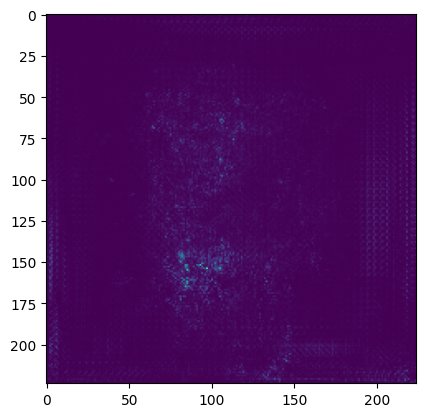

In [111]:
plt.imshow(saliency_IDGI[1])